<a href="https://www.kaggle.com/code/samithsachidanandan/ambulance-detection-cnn?scriptVersionId=291089033" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
!pip install protobuf==3.20.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 3.20.3 which is incompatible.
onnx 1.20.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
ray 2.52.1 requires click!=8.3.*,>=7.0, but you have click 8.3.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.

In [2]:
import tensorflow as tf 
import matplotlib.pyplot as plt 

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2026-01-10 11:07:13.476596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768043233.674560      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768043233.743974      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768043234.220770      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768043234.220811      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768043234.220814      17 computation_placer.cc:177] computation placer alr

# Config

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 100
DATA_DIR ='/kaggle/input/ambulance-dataset/carsdataset'

# Loading the data

In [4]:
dataset =tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    shuffle = True, 
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    )

Found 4749 files belonging to 2 classes.


2026-01-10 11:07:33.937833: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
class_names = dataset.class_names
class_names

['ambulance', 'noambulance']

In [6]:
len(dataset)

75

# Visualizing the samples

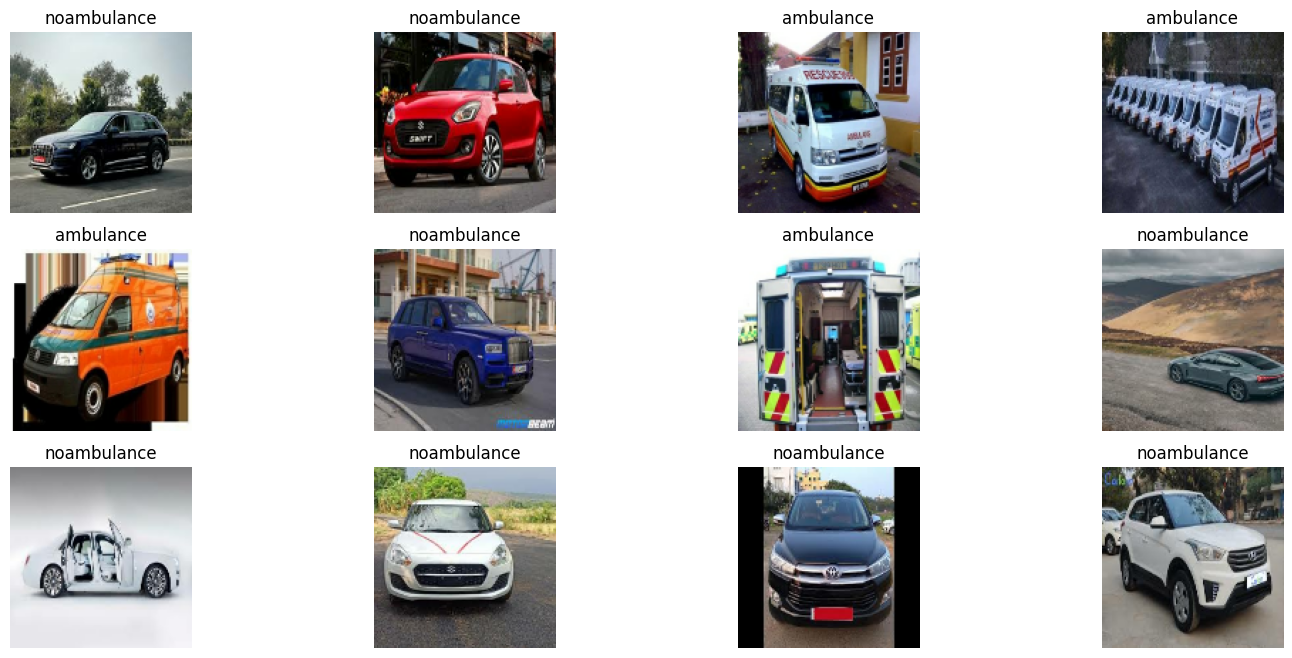

In [7]:
plt.figure(figsize=(18,8))
for image_batch, label_batch in dataset.take(1):

    num_images = min(12, len(image_batch)) 
    
    for i in range(num_images):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])   
        plt.axis('off')



# Train-Val-Test Split

In [8]:
def get_dataset_partitions_tf (ds,train_split=0.6, val_split=0.20, test_split=0.20, shuffle=True,shuffle_size=10000 ):

    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=42)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds 

In [9]:
train_ds, val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Model

In [11]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=input_shape), 
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.1),   

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
   

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax'),
])


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,802 (471.88 KB)

 Trainable params: 120,034 (468.88 KB)

 Non-trainable params: 768 (3.00 KB)

In [13]:
model.compile(
        optimizer = 'adam',
        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics =['accuracy']
)

In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',           
    patience=15,                  
    restore_best_weights=True,   
    verbose=1                     
)

# Training

In [15]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,               
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],  
    verbose=1
)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.6799 - loss: 0.6904 - val_accuracy: 0.5542 - val_loss: 0.8511
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step - accuracy: 0.9134 - loss: 0.2331 - val_accuracy: 0.5667 - val_loss: 0.7839
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9367 - loss: 0.1614 - val_accuracy: 0.8260 - val_loss: 0.3461
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 173s 4s/step - accuracy: 0.9550 - loss: 0.1311 - val_accuracy: 0.8260 - val_loss: 0.3191
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 4s/step - accuracy: 0.9533 - loss: 0.1181 - val_accuracy: 0.9604 - val_loss: 0.1140
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9554 - loss: 0.1198 - val_accuracy: 0.8833 - val_loss: 0.2963
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step - accuracy: 0.9474 - loss: 0.1229 - val_accuracy: 0.7740 - val_loss: 0.5419
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 166s 4s/step - accuracy: 0.9785 - loss: 0.0627 - val_accuracy: 0.

In [16]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 623ms/step - accuracy: 0.9972 - loss: 0.0203


In [17]:
print(f"Test Accuracy: {scores[1]*100:.2f}%")

Test Accuracy: 99.48%


# Plotting the result 

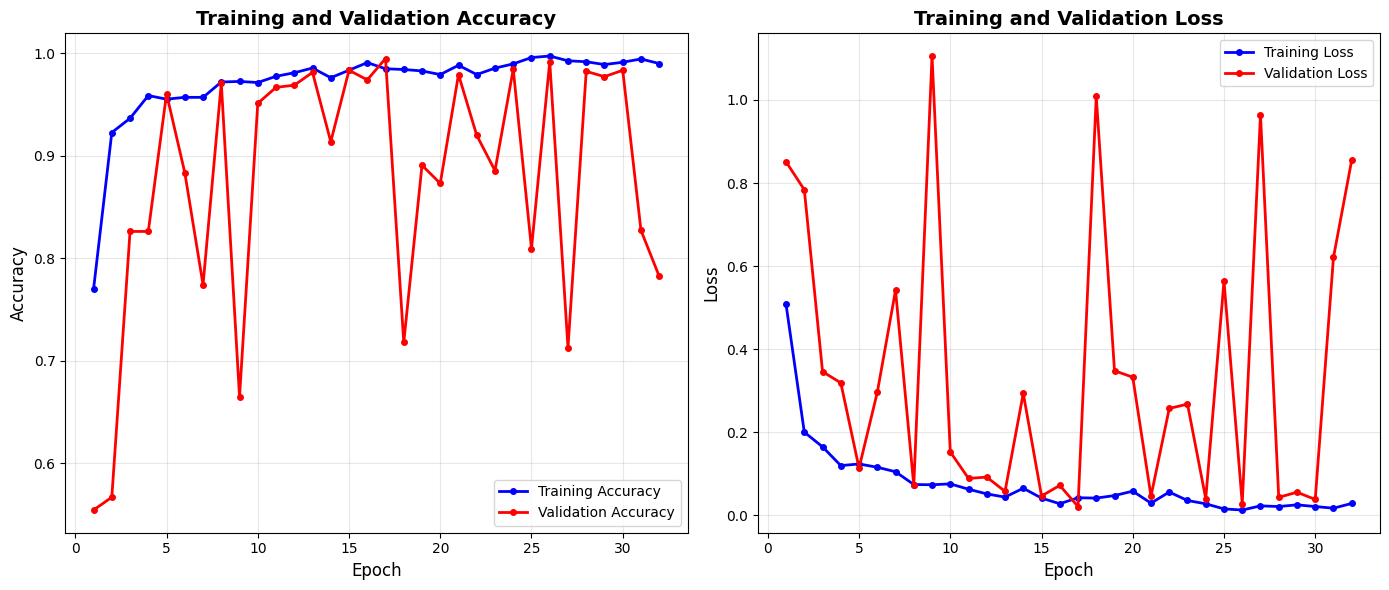


Training Summary:
Total epochs trained: 32
Best validation accuracy: 0.9948 (Epoch 17)
Final training accuracy: 0.9899
Final validation accuracy: 0.7823
Final training loss: 0.0289
Final validation loss: 0.8552



In [18]:
def plot_training_history(history):
    
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    

    epochs_range = range(1, len(acc) + 1)
    
    plt.figure(figsize=(14, 6))
    
  
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'b-o', label='Training Accuracy', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_acc, 'r-o', label='Validation Accuracy', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
  
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'b-o', label='Training Loss', linewidth=2, markersize=4)
    plt.plot(epochs_range, val_loss, 'r-o', label='Validation Loss', linewidth=2, markersize=4)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
  
    total_epochs = len(acc)
    best_epoch = val_acc.index(max(val_acc)) + 1
    print(f"\n{'='*50}")
    print(f"Training Summary:")
    print(f"{'='*50}")
    print(f"Total epochs trained: {total_epochs}")
    print(f"Best validation accuracy: {max(val_acc):.4f} (Epoch {best_epoch})")
    print(f"Final training accuracy: {acc[-1]:.4f}")
    print(f"Final validation accuracy: {val_acc[-1]:.4f}")
    print(f"Final training loss: {loss[-1]:.4f}")
    print(f"Final validation loss: {val_loss[-1]:.4f}")
    print(f"{'='*50}\n")



plot_training_history(history)


# Saving the Model 

In [19]:
model.save("ambulance_classifier.keras") 